In [2]:
from pathlib import Path
from typing import List
import logging
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

def extract_param_from_string(string, param: str) -> str:
    """
    Extract parameter values from string using regex.
    Returns a dict {param: value}
    """
    # Match param=<anything>, (comma required after value)
    match = re.search(rf"{param}=([^,]+),", string)
    if match:
        return match.group(1)
    else: 
        return "not found"

def get_grid_search_dirs(results_directory, results_subdir_identifier, dir_ids):
    """
    Find all subdirectories in results_directory (recursively) whose names contain
    results_subdir_identifier and all strings in dir_ids.
    Returns a list of Path objects.
    """
    subdirs = results_directory.rglob("*")
    print(
        f"Searching in {results_directory} for subdirectories containing '{results_subdir_identifier}' and {dir_ids}"
    )
    print(f"Found {len(list(subdirs))} subdirectories in total.")

    matching_dirs = []
    subdirs = results_directory.rglob("*")
    for subdir in subdirs:
        if not subdir.is_dir():
            continue
        name = subdir.name
        if results_subdir_identifier in name and all(did in name for did in dir_ids):
            print(f"Matched directory: {subdir}")
            matching_dirs.append(subdir)
    return matching_dirs

def create_grid_search_data(dir_list, results_name, params_to_track):
    """
    Given a list of pathlib.Path objects (directories), load the CSV file named <results_name>.csv
    from each directory and concatenate them into a single pandas DataFrame.
    Returns the concatenated DataFrame.
    params_to_track is a list of parameters to track in the DataFrame.
    They are contained in the directory names
    """
    dataframes = []
    for d in dir_list:
        csv_path = d / f"{results_name}.csv"
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            df['source_dir'] = str(d)  # Optionally track source directory
            for param in params_to_track:
                param_value = extract_param_from_string(str(d), param)
                df[param] = param_value
            dataframes.append(df)
        else:
            logging.warning(f"CSV file not found: {csv_path}")
    if dataframes:
        return pd.concat(dataframes, ignore_index=True)
    else:
        return pd.DataFrame()


def xy_grid_plot(data, group_name, x_par, y_par, c_pars):
    data[group_name] = data[group_name].astype(int)
    groups = data.sort_values(group_name).groupby(group_name)
    cpar_min = data[c_pars].values.min()
    cpar_max = data[c_pars].values.max()
    x_lim = (data[x_par].min() - data[x_par].min()/50, data[x_par].max()+ data[x_par].max()/50)
    y_lim = (data[y_par].min() - data[y_par].min()/50, data[y_par].max()+ data[y_par].max()/50)
    for group_id, group in groups:
        avg = group.groupby([x_par, y_par])[c_pars].mean().reset_index()
        fig, axes = plt.subplots(1, len(c_pars), figsize=(5 * len(c_pars), 5), sharex=True, sharey=True)
        if len(c_pars) == 1:
            axes = [axes]
        for ax, c_par in zip(axes, c_pars):
            norm = plt.Normalize(cpar_min, cpar_max)
            # Map color for each point using normalized value
            colors = plt.cm.Spectral(norm(avg[c_par].values))
            scatter = ax.scatter(
                avg[x_par], avg[y_par], c=colors, s=500
            )
            ax.set_title(f"{c_par} (H={group_id})")
            ax.set_xlim(x_lim)
            ax.set_ylim(y_lim)
            ax.set_xlabel(x_par)
            ax.set_ylabel(y_par)
            # Create a colorbar with the same normalization
            sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax)
            cbar.set_label(c_par)
        plt.tight_layout()
        plt.show()

## Threshold values optimization

In [68]:
# the directory containing the results
results_directory = Path("../multirun/baseline_tuning")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = ["threshold"]
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)

data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data

Searching in ../multirun/baseline_tuning for subdirectories containing 'cfg' and ['threshold']
Found 8035 subdirectories in total.
Matched directory: ../multirun/baseline_tuning/2025-05-30-18-46-11/cfg:+threshold_hidden_values=[0.5,0.75,1.0],+threshold_readout_values=[2.5,3.0,3.5,4.0],H=300,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-05-30-18-46-11/cfg:+threshold_hidden_values=[0.5,0.75,1.0],+threshold_readout_values=[2.5,3.0,3.5,4.0],H=1000,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-05-30-18-46-11/cfg:+threshold_hidden_values=[0.5,0.75,1.0],+threshold_readout_values=[2.5,3.0,3.5,4.0],H=3000,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-05-30-18-44-11/cfg:+threshold_hidden_values=[0.5,0.75,1.0],+threshold_readout_values=[2.5,3.0,3.5,4.0],H=300,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-05-30-18-44-11/cfg:+threshold_hidden_values=[0.5,0.75,1.0],+threshold_readout_values=[2.5,3.0,3.5,4.0],H=1000,device=cuda
M

Matched directory: ../multirun/baseline_tuning/2025-06-02-20-32-08/cfg:+threshold_hidden_values=[1.25,1.5,2.0],+threshold_readout_values=[3.0,3.5],H=400,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-06-02-20-32-08/cfg:+threshold_hidden_values=[1.25,1.5,2.0],+threshold_readout_values=[3.0,3.5],H=1600,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-06-02-20-32-08/cfg:+threshold_hidden_values=[1.25,1.5,2.0],+threshold_readout_values=[3.0,3.5],H=3200,device=cuda


,threshold_hidden,threshold_readout,max_train_acc,final_train_acc,max_eval_acc,final_eval_acc,source_dir,H
0,0.50,2.5,0.749117,0.552183,0.7501,0.5541,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
1,0.50,3.0,0.753767,0.565200,0.7530,0.5592,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
2,0.50,3.5,0.748083,0.543333,0.7475,0.5417,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
3,0.50,4.0,0.753800,0.547883,0.7580,0.5416,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
4,0.75,2.5,0.829300,0.822400,0.8089,0.8042,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
5,0.75,3.0,0.829633,0.826083,0.8072,0.8028,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
6,0.75,3.5,0.825300,0.824683,0.8053,0.8037,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
7,0.75,4.0,0.828500,0.828500,0.8099,0.8099,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
8,1.00,2.5,0.844150,0.840667,0.8270,0.8216,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
9,1.00,3.0,0.847233,0.845733,0.8324,0.8270,../multirun/baseline_tuning/2025-05-30-18-46-1...,300


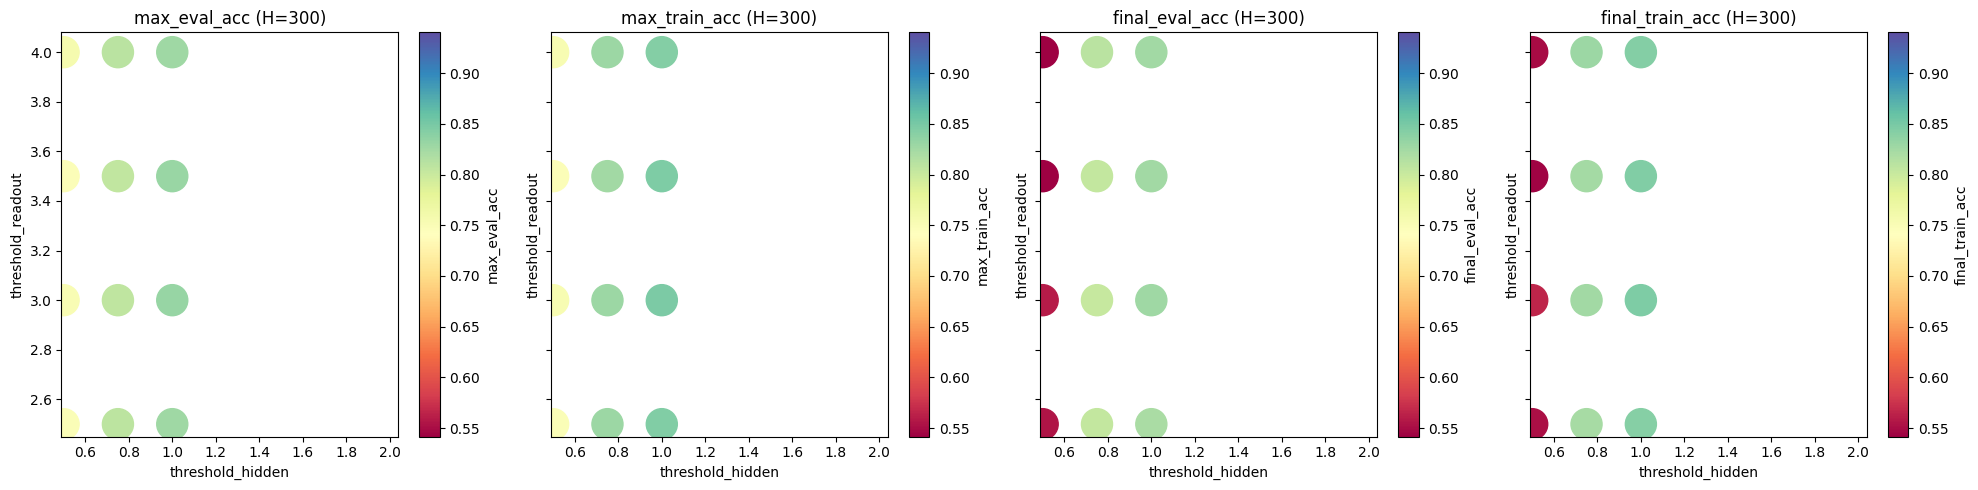

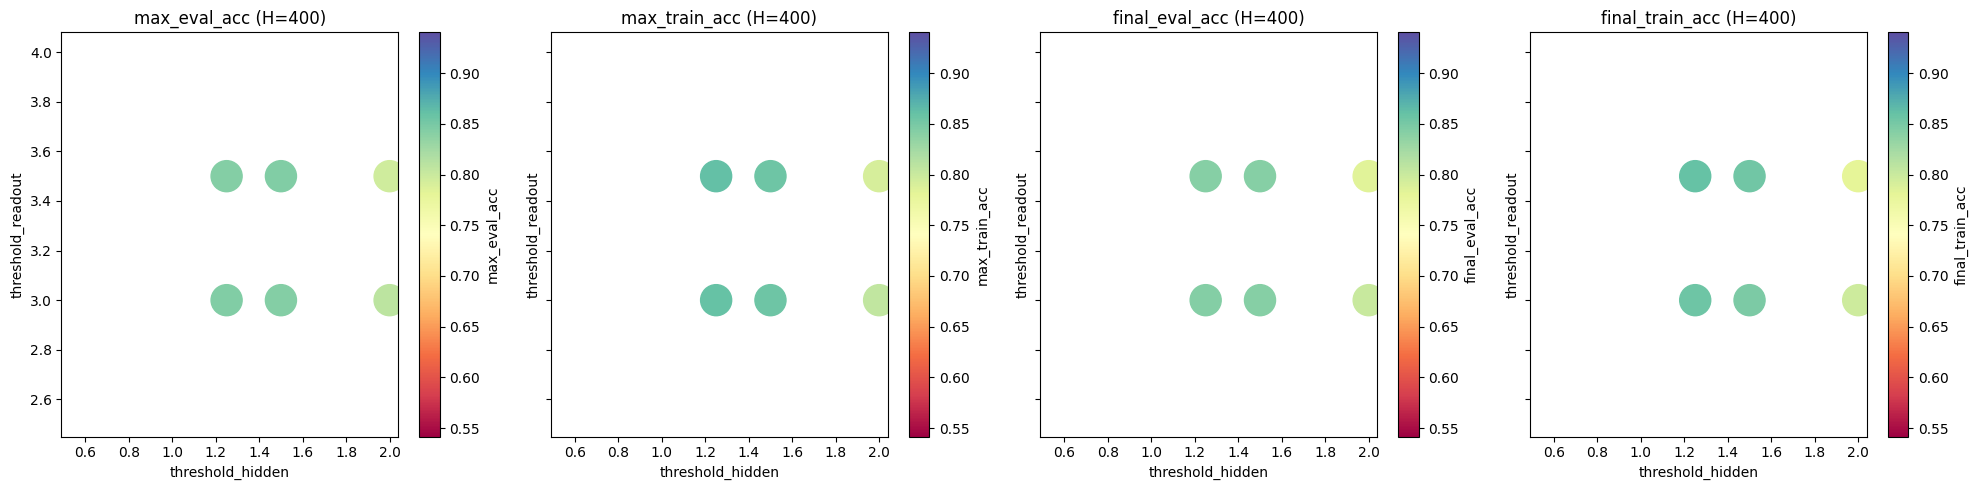

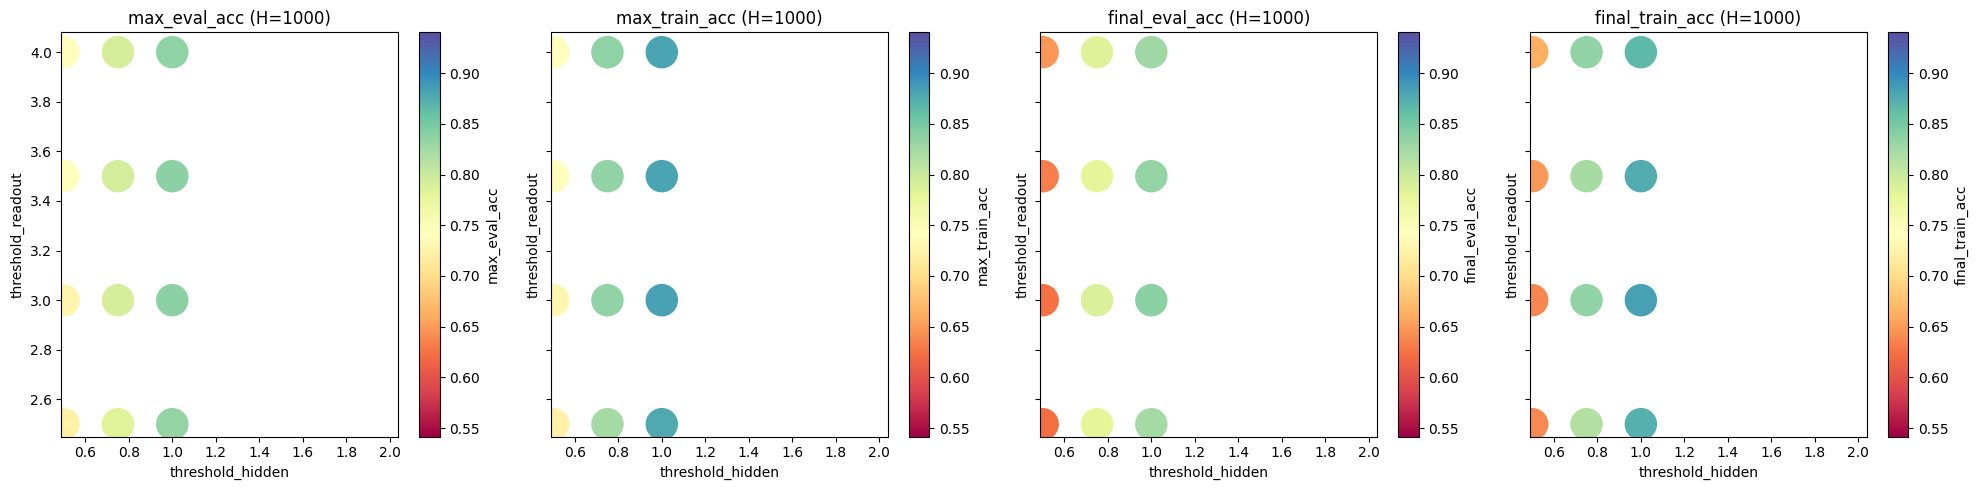

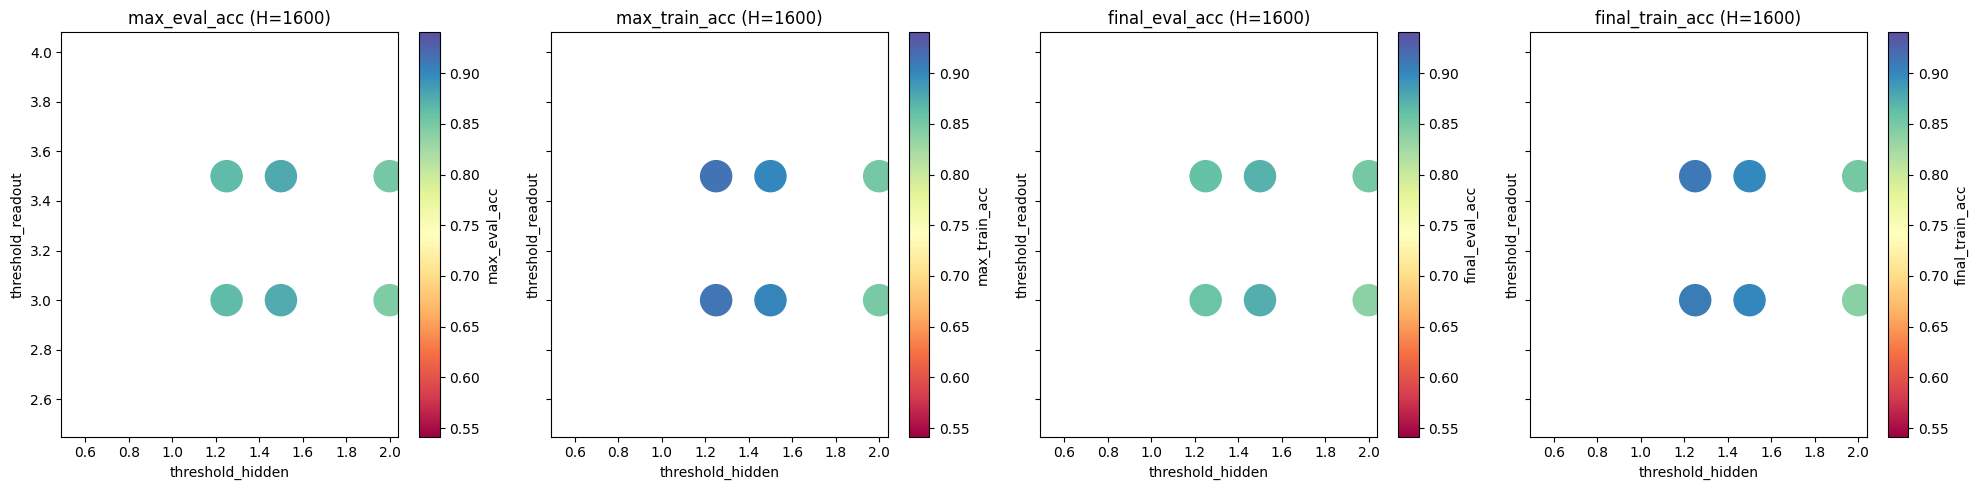

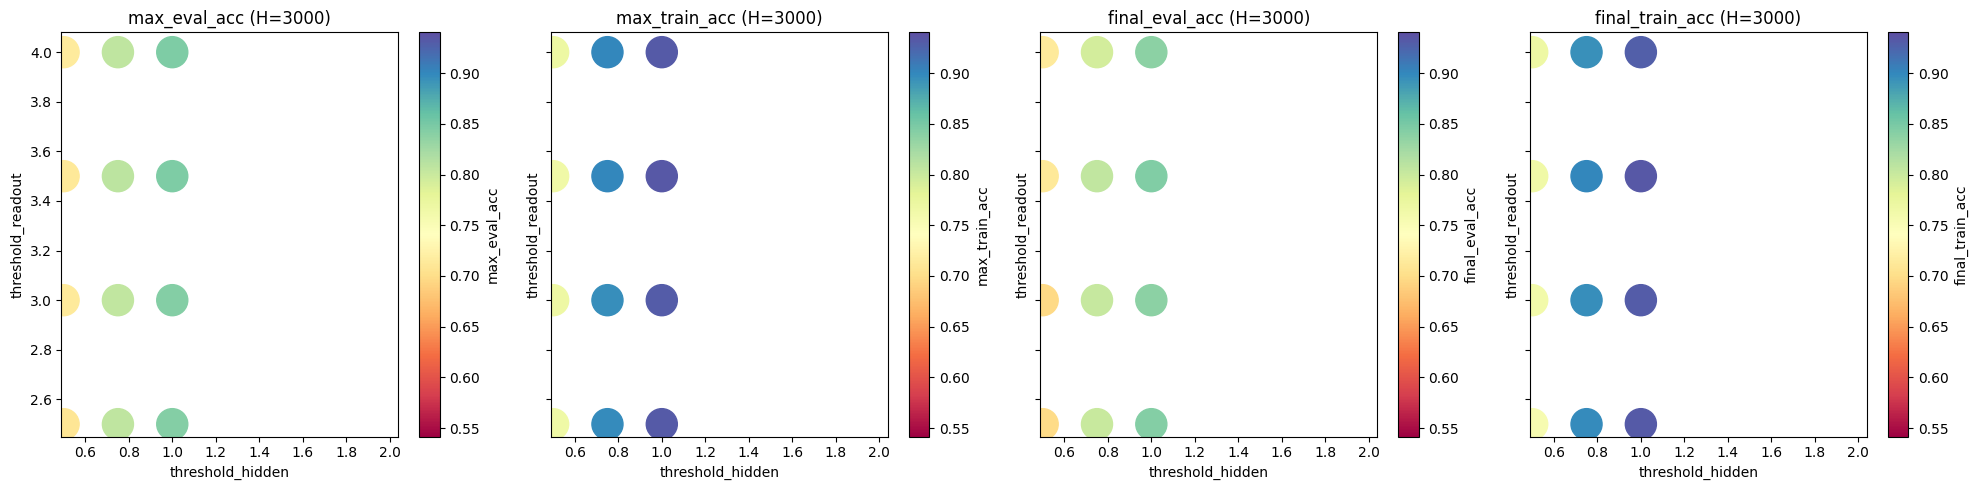

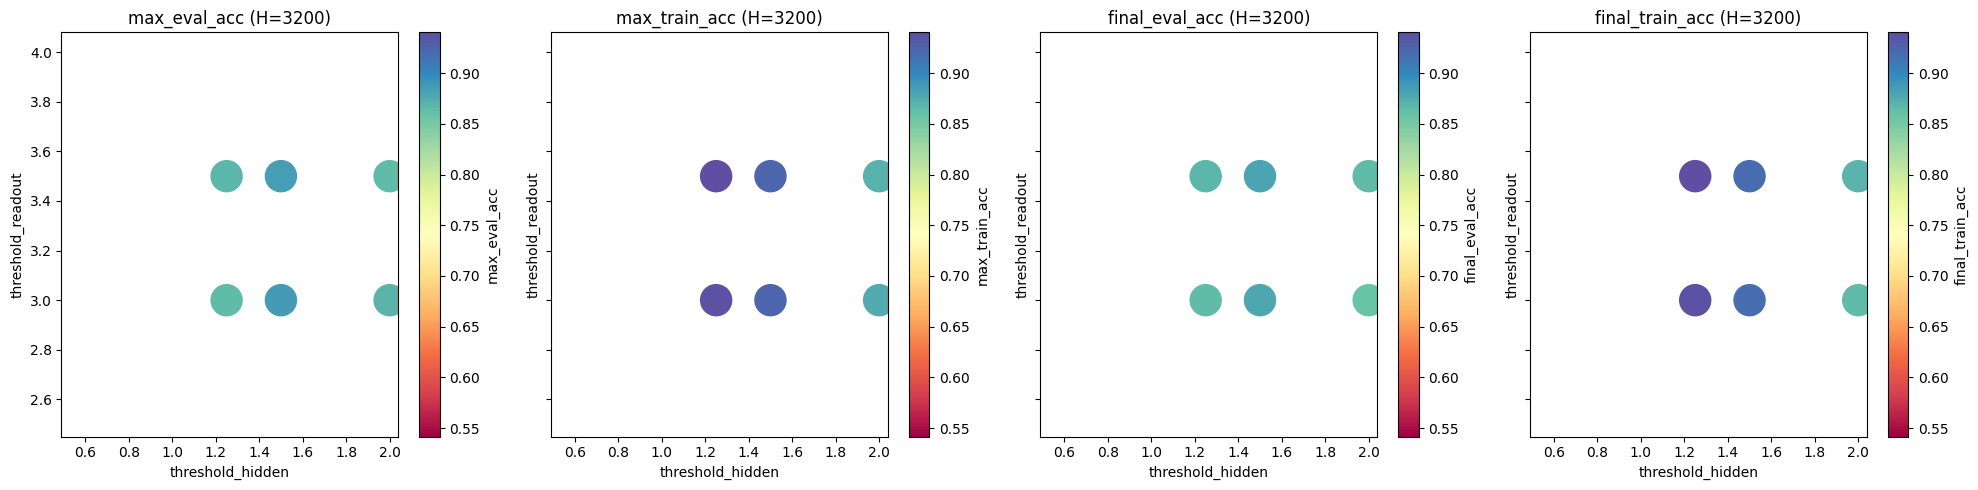

In [69]:
group_name = "H"
x_par = "threshold_hidden"
y_par = "threshold_readout"
c_pars = [
    "max_eval_acc",
    "max_train_acc",
    "final_eval_acc",
    "final_train_acc",
]
xy_grid_plot(
    data,
    group_name,
    x_par,
    y_par,
    c_pars
)

## Lambdas optimization

In [70]:
# the directory containing the results
results_directory = Path("../multirun/baseline_tuning")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = ["lambda", "epochs"]
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)

data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data = data.dropna(axis="index", how="any")
data

Searching in ../multirun/baseline_tuning for subdirectories containing 'cfg' and ['lambda', 'epochs']
Found 8035 subdirectories in total.
Matched directory: ../multirun/baseline_tuning/2025-06-04-10-37-12/cfg:+lambda_input_skip_values=[2.0,1.5,1.0,0.5,0.3],+lambda_wback_values=[1.0,1.5],H=400,device=cuda,num_epochs=100
Matched directory: ../multirun/baseline_tuning/2025-06-03-17-55-41/cfg:+lambda_input_skip_values=[2.0,1.5,1.0,0.5,0.3],+lambda_wback_values=[0.5,0.6,0.8],H=400,device=cuda,num_epochs=100
Matched directory: ../multirun/baseline_tuning/2025-06-04-11-42-18/cfg:+lambda_wback_values=[1.0,1.5],H=3200,device=cuda,num_epochs=100


,lambda_wback,lambda_input_skip,max_train_acc,final_train_acc,max_eval_acc,final_eval_acc,source_dir,H
0,1.0,2.0,0.841983,0.827717,0.8323,0.8124,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
1,1.0,1.5,0.845183,0.831317,0.8374,0.8148,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
2,1.0,1.0,0.840067,0.833283,0.8340,0.8196,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
3,1.0,0.5,0.838700,0.830833,0.8311,0.8212,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
4,1.0,0.3,0.837800,0.835017,0.8335,0.8223,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
5,1.5,2.0,0.780967,0.648900,0.7807,0.6419,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
6,1.5,1.5,0.781767,0.710867,0.7780,0.7047,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
7,1.5,1.0,0.773467,0.649383,0.7808,0.6472,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
8,1.5,0.5,0.774450,0.611967,0.7778,0.6135,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
9,1.5,0.3,0.774750,0.596517,0.7759,0.6016,../multirun/baseline_tuning/2025-06-04-10-37-1...,400


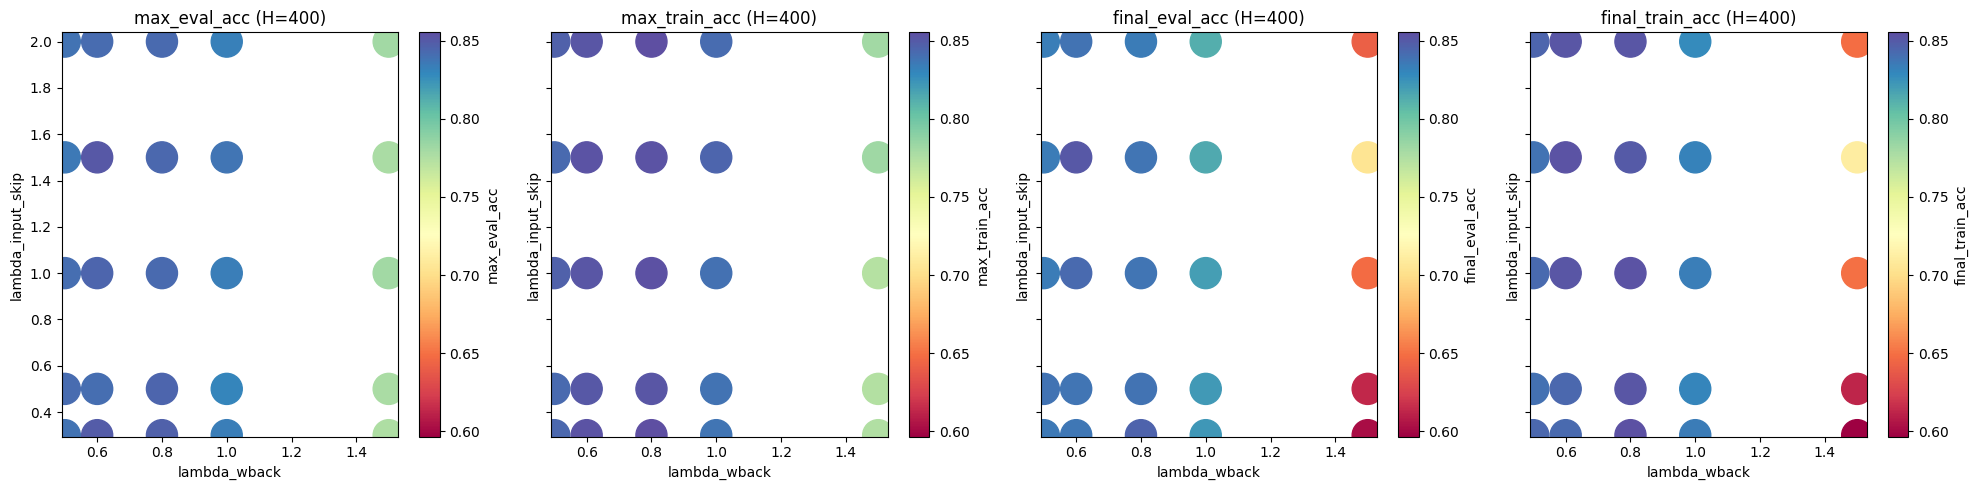

In [71]:
group_name = "H"
x_par = "lambda_wback"
y_par = "lambda_input_skip"
c_pars = [
    "max_eval_acc",
    "max_train_acc",
    "final_eval_acc",
    "final_train_acc",
]
xy_grid_plot(
    data,
    group_name,
    x_par,
    y_par,
    c_pars
)

# Baseline plots

### Plot da fare:
- Per baseline trovati parametri giusti. Abbiamo evidenziato che la dinamica interna e' importante.
    - Plot con e senza lambda_internal
    - Plot a diverse lunghezze di dinamica


In [3]:
## plot con e senza dinamica interna
# the directory containing the results
results_directory = Path("../multirun/baseline_tuning/no_lambda_internal")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = []
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)

data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data_no_internal = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
data_no_internal.index = data_no_internal.index.astype(int)

#
# data with internal dyncamics 
#
# the directory containing the results
results_directory = Path("../multirun/baseline_tuning/final_baseline_search")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = []
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)

data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data_internal = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
data_internal.index = data_internal.index.astype(int)
data_internal


#
# data with internal dyncamics 
#
# the directory containing the results
results_directory = Path("../multirun/baseline_tuning/random_internal_couplings")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = []
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)

data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data_random = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
data_random.index = data_internal.index.astype(int)
data_random

Searching in ../multirun/baseline_tuning/no_lambda_internal for subdirectories containing 'cfg' and []
Found 1103 subdirectories in total.
Matched directory: ../multirun/baseline_tuning/no_lambda_internal/cfg:+lambda_input_skip_values=[6.0,3.0,4.0,5.0,10.0,20.0],H=1600,device=cuda,lambda_internal=0.0,max_steps_train=7,num_epochs=100
Matched directory: ../multirun/baseline_tuning/no_lambda_internal/cfg:+lambda_input_skip_values=[6.0,3.0,4.0,5.0,10.0,20.0],H=3200,device=cuda,lambda_internal=0.0,max_steps_train=7,num_epochs=100
Matched directory: ../multirun/baseline_tuning/no_lambda_internal/cfg:+lambda_input_skip_values=[6.0,3.0,4.0,5.0,10.0,20.0],H=400,device=cuda,lambda_internal=0.0,max_steps_train=7,num_epochs=100
Searching in ../multirun/baseline_tuning/final_baseline_search for subdirectories containing 'cfg' and []
Found 1118 subdirectories in total.
Matched directory: ../multirun/baseline_tuning/final_baseline_search/cfg:+lambda_input_skip_values=[6.0,3.0,4.0,5.0,10.0,20.0],H=160

/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/797236854.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_no_internal = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/797236854.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_internal = data.dropna(axis="

,lambda_input_skip,max_train_acc,final_train_acc,max_eval_acc,final_eval_acc,source_dir,H
H,,,,,,,
1600,20.0,0.845667,0.845267,0.8368,0.8341,../multirun/baseline_tuning/random_internal_co...,1600
3200,20.0,0.867633,0.863950,0.8499,0.8456,../multirun/baseline_tuning/random_internal_co...,3200
400,20.0,0.816717,0.809700,0.8183,0.8092,../multirun/baseline_tuning/random_internal_co...,400


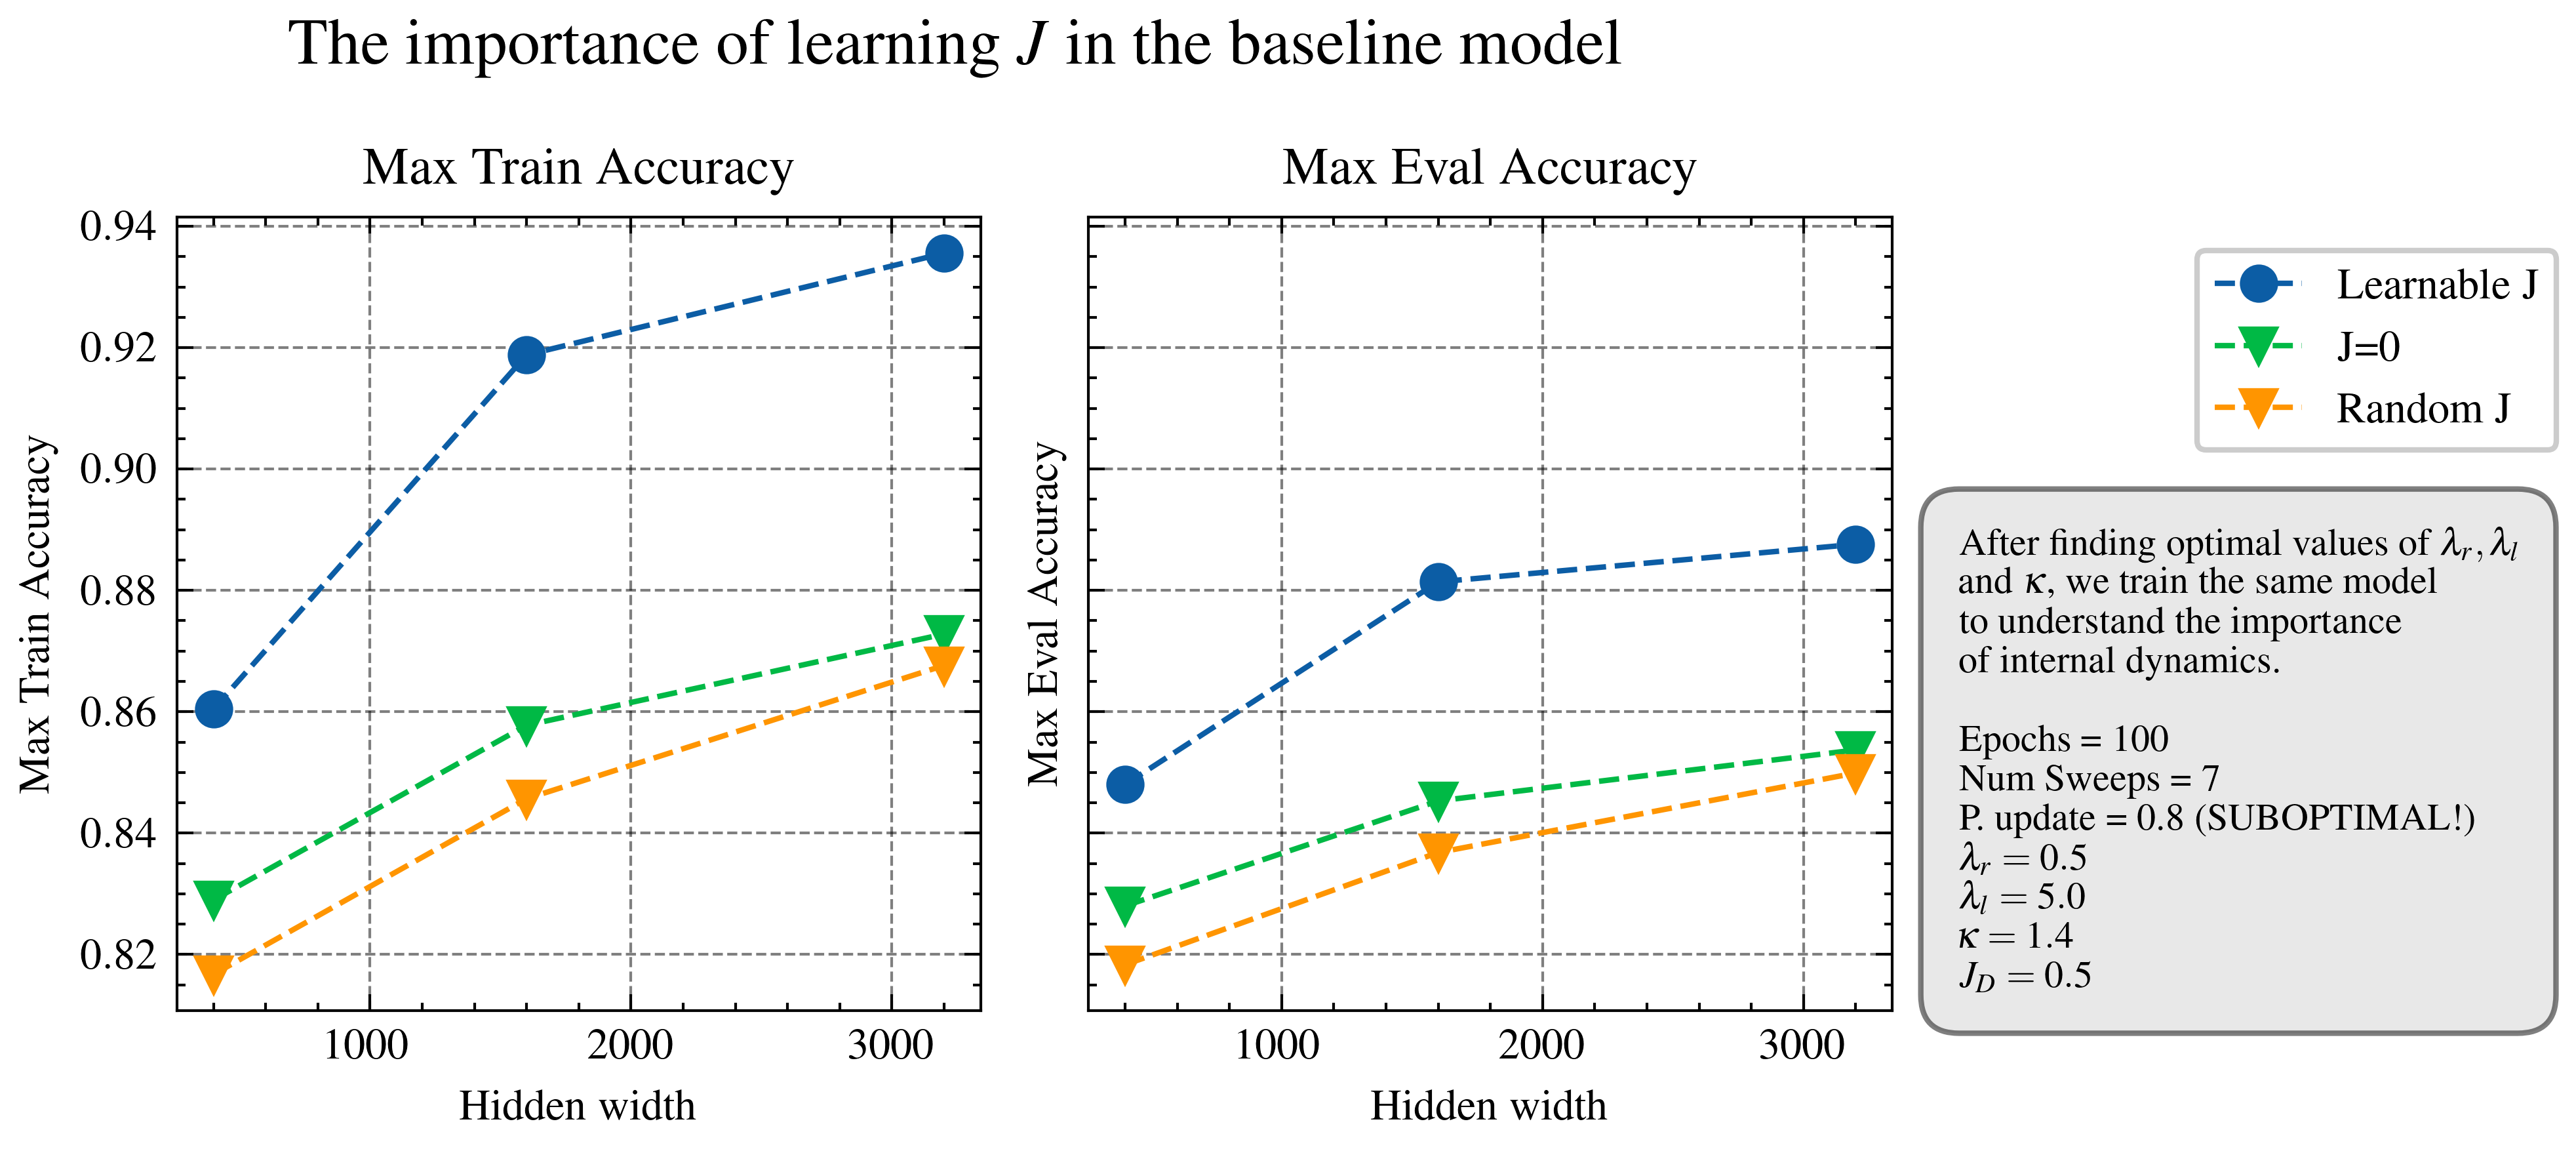

In [5]:
import scienceplots
from matplotlib.patches import FancyBboxPatch
plt.style.use(["ieee", "science", "grid"])
fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharex=True, sharey=True, tight_layout=True)
plot_description = """After finding optimal values of $\lambda_r, \lambda_l$
and $\kappa$, we train the same model 
to understand the importance 
of internal dynamics.

Epochs = 100
Num Sweeps = 7
P. update = 0.8 (SUBOPTIMAL!)
$\lambda_r = 0.5$
$\lambda_l = 5.0$
$\kappa = 1.4$
$J_D=0.5$"""

# Ensure H is sorted numerically for plotting
h_sorted = sorted(data_internal.index.astype(int))

# Plot max_train_acc
axes[0].plot(
    h_sorted,
    data_internal.loc[h_sorted, "max_train_acc"],
    marker="o",
    linestyle='--',
    label="No internal couplings"
)
axes[0].plot(
    h_sorted,
    data_no_internal.loc[h_sorted, "max_train_acc"],
    marker="v",
    linestyle='--',
    label="No internal couplings"
)
axes[0].plot(
    h_sorted,
    data_random.loc[h_sorted, "max_train_acc"],
    marker="v",
    linestyle='--',
    label="Random internal couplings"
)
axes[0].set_xlabel("Hidden width")
axes[0].set_ylabel("Max Train Accuracy")
axes[0].set_title("Max Train Accuracy")
# Remove individual legends and create a single legend outside the plots

# Plot max_eval_acc
axes[1].plot(
    h_sorted,
    data_internal.loc[h_sorted, "max_eval_acc"],
    marker="o",
    linestyle='--',
    label="Learnable internal couplings"
)
axes[1].plot(
    h_sorted,
    data_no_internal.loc[h_sorted, "max_eval_acc"],
    marker="v",
    linestyle='--',
    label="No internal couplings"
)
axes[1].plot(
    h_sorted,
    data_random.loc[h_sorted, "max_eval_acc"],
    marker="v",
    linestyle='--',
    label="Random internal couplings"
)
axes[1].set_xlabel("Hidden width")
axes[1].set_ylabel("Max Eval Accuracy")
axes[1].set_title("Max Eval Accuracy")


handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, ["Learnable J", "J=0", "Random J"], loc="center left", bbox_to_anchor=(1.12, 0.7))
fig.suptitle("The importance of learning $J$ in the baseline model", fontsize=12)
# Add the text
props = dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.5)
text = fig.text(1.01, 0.55, plot_description, ha="left", fontsize=7, va="top", bbox=props)
plt.show()

In [21]:
## plot con dinamica a diverse lunghezze
# the directory containing the results
results_directory = Path("../multirun/dynamics_length_search")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = []
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)

data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
max_length_groups = data.groupby("max_steps_train")
groups = {}
for group_id, group in max_length_groups:
    group = group.dropna(axis="index", how="any").groupby(["H"]).apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
    group.index = group.index.astype(int)
    groups[group_id] = group

Searching in ../multirun/dynamics_length_search for subdirectories containing 'cfg' and []
Found 1502 subdirectories in total.
Matched directory: ../multirun/dynamics_length_search/2025-06-10-11-51-14/cfg:+max_steps_train_values=[2,10,20,40],H=3200,device=cuda,num_epochs=100
Matched directory: ../multirun/dynamics_length_search/2025-06-10-11-51-14/cfg:+max_steps_train_values=[2,10,20,40],H=1600,device=cuda,num_epochs=100
Matched directory: ../multirun/dynamics_length_search/2025-06-10-11-51-14/cfg:+max_steps_train_values=[2,10,20,40],H=400,device=cuda,num_epochs=100
Matched directory: ../multirun/dynamics_length_search/2025-06-12-09-45-52/cfg:+max_steps_train_values=[2,10,20,40],H=1600,device=cuda,num_epochs=100,p_update=1.0
Matched directory: ../multirun/dynamics_length_search/2025-06-12-09-45-52/cfg:+max_steps_train_values=[2,10,20,40],H=400,device=cuda,num_epochs=100,p_update=1.0
Matched directory: ../multirun/dynamics_length_search/2025-06-12-09-45-52/cfg:+max_steps_train_values=[2

/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/3462582950.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group = group.dropna(axis="index", how="any").groupby(["H"]).apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/3462582950.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group = group.dropna(axis="index", how="

In [49]:
groups[20]

,max_steps_train,max_train_acc,final_train_acc,max_eval_acc,final_eval_acc,source_dir,H
H,,,,,,,
1600,20,0.905167,0.900733,0.8640,0.8552,../multirun/dynamics_length_search/2025-06-12-...,1600
3200,20,0.939283,0.933167,0.8794,0.8660,../multirun/dynamics_length_search/2025-06-12-...,3200
400,20,0.834450,0.831800,0.8248,0.8169,../multirun/dynamics_length_search/2025-06-12-...,400


/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/903369976.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(groups))


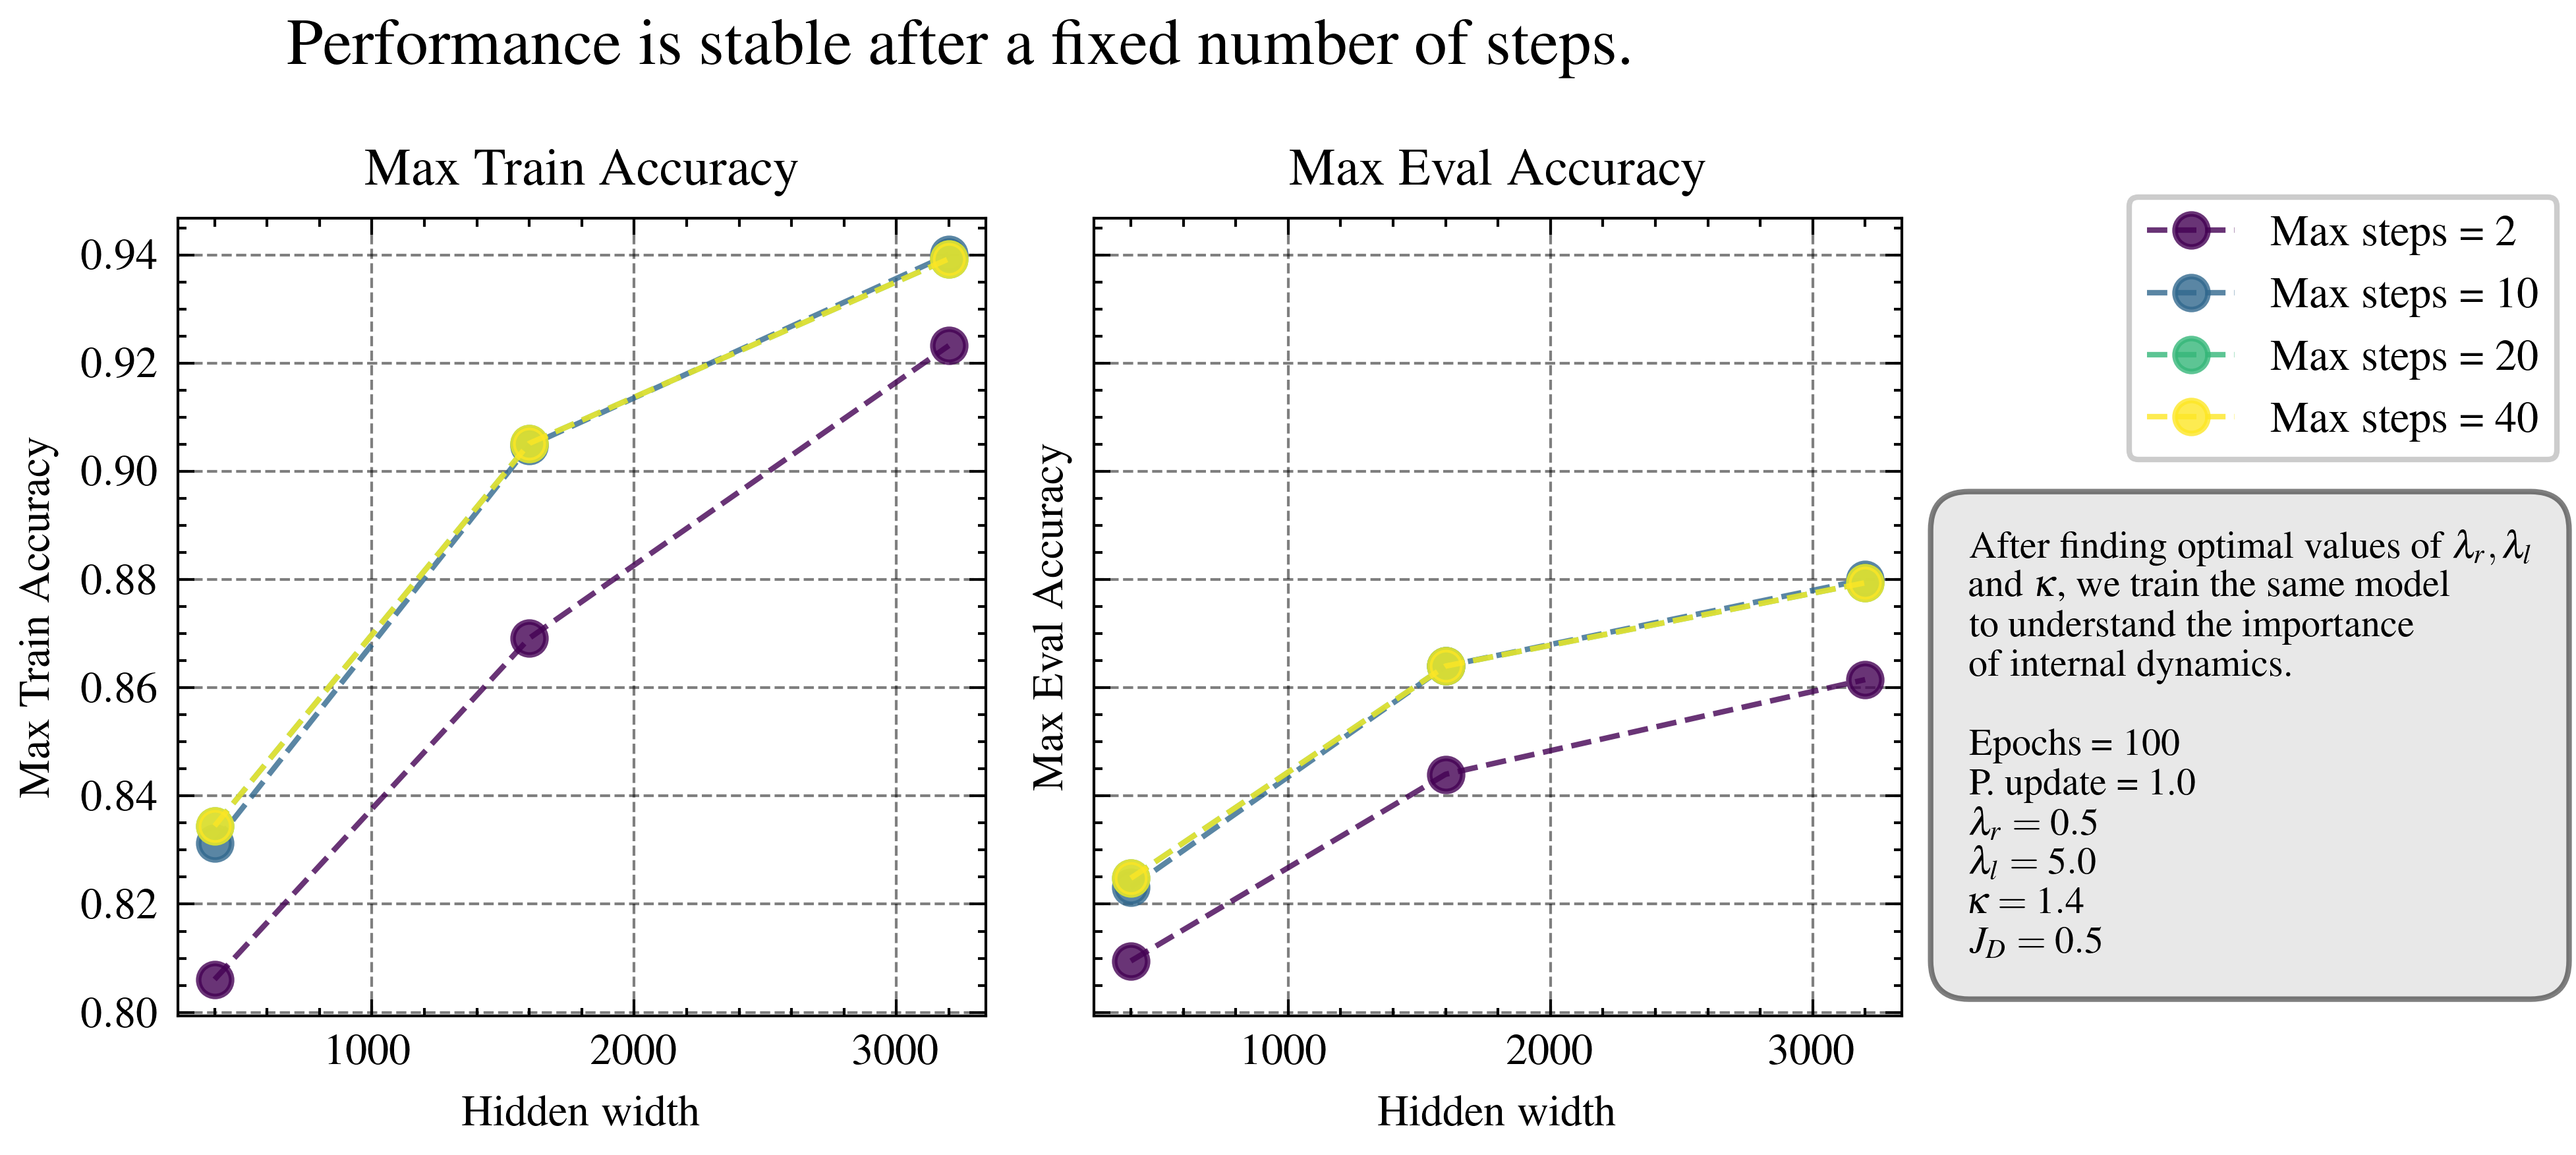

In [56]:
import scienceplots
from matplotlib.patches import FancyBboxPatch
import numpy as np
plt.style.use(["ieee", "science", "grid"])
fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharex=True, sharey=True, tight_layout=True)
plot_description = """After finding optimal values of $\lambda_r, \lambda_l$
and $\kappa$, we train the same model 
to understand the importance 
of internal dynamics.

Epochs = 100
P. update = 1.0
$\lambda_r = 0.5$
$\lambda_l = 5.0$
$\kappa = 1.4$
$J_D=0.5$"""

# Ensure H is sorted numerically for plotting
h_sorted = sorted(data_internal.index.astype(int))

# Plot max_train_acc
# Define a colormap
import matplotlib.cm as cm

cmap = cm.get_cmap("viridis", len(groups))
colors = [cmap(i) for i in range(len(groups))]

for idx, (group_id, group) in enumerate(groups.items()):
    axes[0].plot(
        h_sorted,
        groups[group_id].loc[h_sorted, "max_train_acc"],
        marker="o",
        linestyle='--',
        label=f"Max steps = {group_id}",
        color=colors[idx],
        alpha=0.8
    )
axes[0].set_xlabel("Hidden width")
axes[0].set_ylabel("Max Train Accuracy")
axes[0].set_title("Max Train Accuracy")
# Remove individual legends and create a single legend outside the plots

# Plot max_eval_acc
for idx, (group_id, group) in enumerate(groups.items()):
    axes[1].plot(
        h_sorted,
        groups[group_id].loc[h_sorted, "max_eval_acc"],
        marker="o",
        linestyle='--',
        label="No internal couplings", 
        color=colors[idx],
        alpha=0.8
    )
axes[1].set_xlabel("Hidden width")
axes[1].set_ylabel("Max Eval Accuracy")
axes[1].set_title("Max Eval Accuracy")


handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, [f"Max steps = {i}" for i in groups.keys()], loc="center left", bbox_to_anchor=(1.08, 0.72))
fig.suptitle("Performance is stable after a fixed number of steps.", fontsize=12)
# Add the text
props = dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.5)
text = fig.text(1.01, 0.55, plot_description, ha="left", fontsize=7, va="top", bbox=props)
plt.show()

# The impact of J_D

- Impatto di J_D
    - Con J_D=0 e dinamica corta si puo' imparare decentemente. Ma si impara meglio con J_D=0.5.
    - Con J_D=0 e dinamica lunga esplode tutto, mentre J_D=0 migliora
    - Con dinamica doppia J_D=0 non va sopra random, mentre J_D=0.5 migliora ancora di piu'

In [97]:
## J_d 0.5
# the directory containing the results
results_directory = Path("../multirun/baseline_tuning/final_baseline_search")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = []
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)
data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data_jd_high = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
data_jd_high.index = data_jd_high.index.astype(int)
data_jd_high


## J_d 0.0
# the directory containing the results
results_directory = Path("../multirun/low_JD_asymmetric")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = ["J_D=0.0"]
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)
data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data_jd_low = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
data_jd_low.index = data_jd_low.index.astype(int)
data_jd_low

## J_d 0.5 - long dynamics
# the directory containing the results
results_directory = Path("../multirun/dynamics_length_search")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = []
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)
data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data_jd_high_long = data.dropna(axis="index", how="any").query("max_steps_train == 40").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
data_jd_high_long.index = data_jd_high_long.index.astype(int)
data_jd_high_long


## J_d 0.0 - long dynamics
# the directory containing the results
results_directory = Path("../multirun/low_JD_asymmetric_v2")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = ["J_D=0.0"]
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)
data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data_jd_low_long = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
data_jd_low_long.index = data_jd_low_long.index.astype(int)
data_jd_low_long

## J_d 0.5 - double dynamics
# the directory containing the results
results_directory = Path("../multirun/low_JD_asymmetric_double_dynamics")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = ["J_D=0.5"]
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)
data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data_jd_high_double = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
data_jd_high_double.index = data_jd_high_double.index.astype(int)
data_jd_high_double


## J_d 0.0 - double dynamics
# the directory containing the results
results_directory = Path("../multirun/low_JD_asymmetric_double_dynamics")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = ["J_D=0.0"]
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)
data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data_jd_low_double = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
data_jd_low_double.index = data_jd_low_double.index.astype(int)
data_jd_low_double

Searching in ../multirun/baseline_tuning/final_baseline_search for subdirectories containing 'cfg' and []
Found 1118 subdirectories in total.
Matched directory: ../multirun/baseline_tuning/final_baseline_search/cfg:+lambda_input_skip_values=[6.0,3.0,4.0,5.0,10.0,20.0],H=1600,device=cuda,max_steps_train=7,num_epochs=100
Matched directory: ../multirun/baseline_tuning/final_baseline_search/cfg:+lambda_input_skip_values=[6.0,3.0,4.0,5.0,10.0,20.0],H=400,device=cuda,max_steps_train=7,num_epochs=100
Matched directory: ../multirun/baseline_tuning/final_baseline_search/cfg:+lambda_input_skip_values=[6.0,3.0,4.0,5.0,10.0,20.0],H=3200,device=cuda,max_steps_train=7,num_epochs=100
Searching in ../multirun/low_JD_asymmetric for subdirectories containing 'cfg' and ['J_D=0.0']
Found 4836 subdirectories in total.
Matched directory: ../multirun/low_JD_asymmetric/2025-06-04-13-09-25/cfg:+lambda_input_skip_values=[2.0,1.0,3.0],+lambda_wback_values=[0.5,0.2,0.8],+threshold_hidden_values=[1.25,1.5,0.5],H=1

/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/1595215820.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_jd_high = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/1595215820.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_jd_low = data.dropna(axis="inde

Matched directory: ../multirun/dynamics_length_search/2025-06-12-09-45-52/cfg:+max_steps_train_values=[2,10,20,40],H=1600,device=cuda,num_epochs=100,p_update=1.0
Matched directory: ../multirun/dynamics_length_search/2025-06-12-09-45-52/cfg:+max_steps_train_values=[2,10,20,40],H=400,device=cuda,num_epochs=100,p_update=1.0
Matched directory: ../multirun/dynamics_length_search/2025-06-12-09-45-52/cfg:+max_steps_train_values=[2,10,20,40],H=3200,device=cuda,num_epochs=100,p_update=1.0
Searching in ../multirun/low_JD_asymmetric_v2 for subdirectories containing 'cfg' and ['J_D=0.0']
Found 1936 subdirectories in total.
Matched directory: ../multirun/low_JD_asymmetric_v2/2025-06-05-09-25-42/cfg:+lambda_input_skip_values=[1.0,3.0],+lambda_wback_values=[0.5,0.8],+threshold_hidden_values=[1.25,1.5,0.5,0.25],H=1600,J_D=0.0,max_steps=20,num_epochs=50,p_update=1.0
Searching in ../multirun/low_JD_asymmetric_double_dynamics for subdirectories containing 'cfg' and ['J_D=0.5']
Found 4372 subdirectories i

/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/1595215820.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_jd_low_long = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])
/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/1595215820.py:129: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_jd_high_double = data.dro

Searching in ../multirun/low_JD_asymmetric_double_dynamics for subdirectories containing 'cfg' and ['J_D=0.0']
Found 4372 subdirectories in total.
Matched directory: ../multirun/low_JD_asymmetric_double_dynamics/low_JD_asymmetric_double_dynamics/2025-06-06-00-40-49/cfg:+lambda_input_skip_values=[1.0,3.0],+lambda_wback_values=[0.5,0.8],+threshold_hidden_values=[1.25,1.5,0.5,0.25],H=1600,J_D=0.0,double_dynamics=True,max_steps_eval=7,max_steps_train=7,num_epochs=50,p_update=1.0
Matched directory: ../multirun/low_JD_asymmetric_double_dynamics/2025-06-06-00-40-49/cfg:+lambda_input_skip_values=[1.0,3.0],+lambda_wback_values=[0.5,0.8],+threshold_hidden_values=[1.25,1.5,0.5,0.25],H=1600,J_D=0.0,double_dynamics=True,max_steps_eval=7,max_steps_train=7,num_epochs=50,p_update=1.0
Matched directory: ../multirun/low_JD_asymmetric_double_dynamics/2025-06-11-12-30-34/cfg:+lambda_input_skip_values=[3.0,5.0],+lambda_wback_values=[0.5],+threshold_hidden_values=[1.4],H=400,J_D=0.0,double_dynamics=True,max

/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/1595215820.py:156: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_jd_low_double = data.dropna(axis="index", how="any").groupby("H").apply(lambda g: g.loc[g["max_eval_acc"].idxmax()])


10,lambda_wback,lambda_input_skip,threshold_hidden,max_train_acc,final_train_acc,max_eval_acc,final_eval_acc,source_dir,H
H,,,,,,,,,
1600,0.8,1.0,0.5,0.11355,0.097367,0.1141,0.0982,../multirun/low_JD_asymmetric_double_dynamics/...,1600


/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/1854289249.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(jd_high_keys, rotation=45, ha="right")
/var/folders/by/82rbn9gj56966xymdg3dctbm0000gn/T/ipykernel_14227/1854289249.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(jd_low_keys, rotation=45, ha="right")


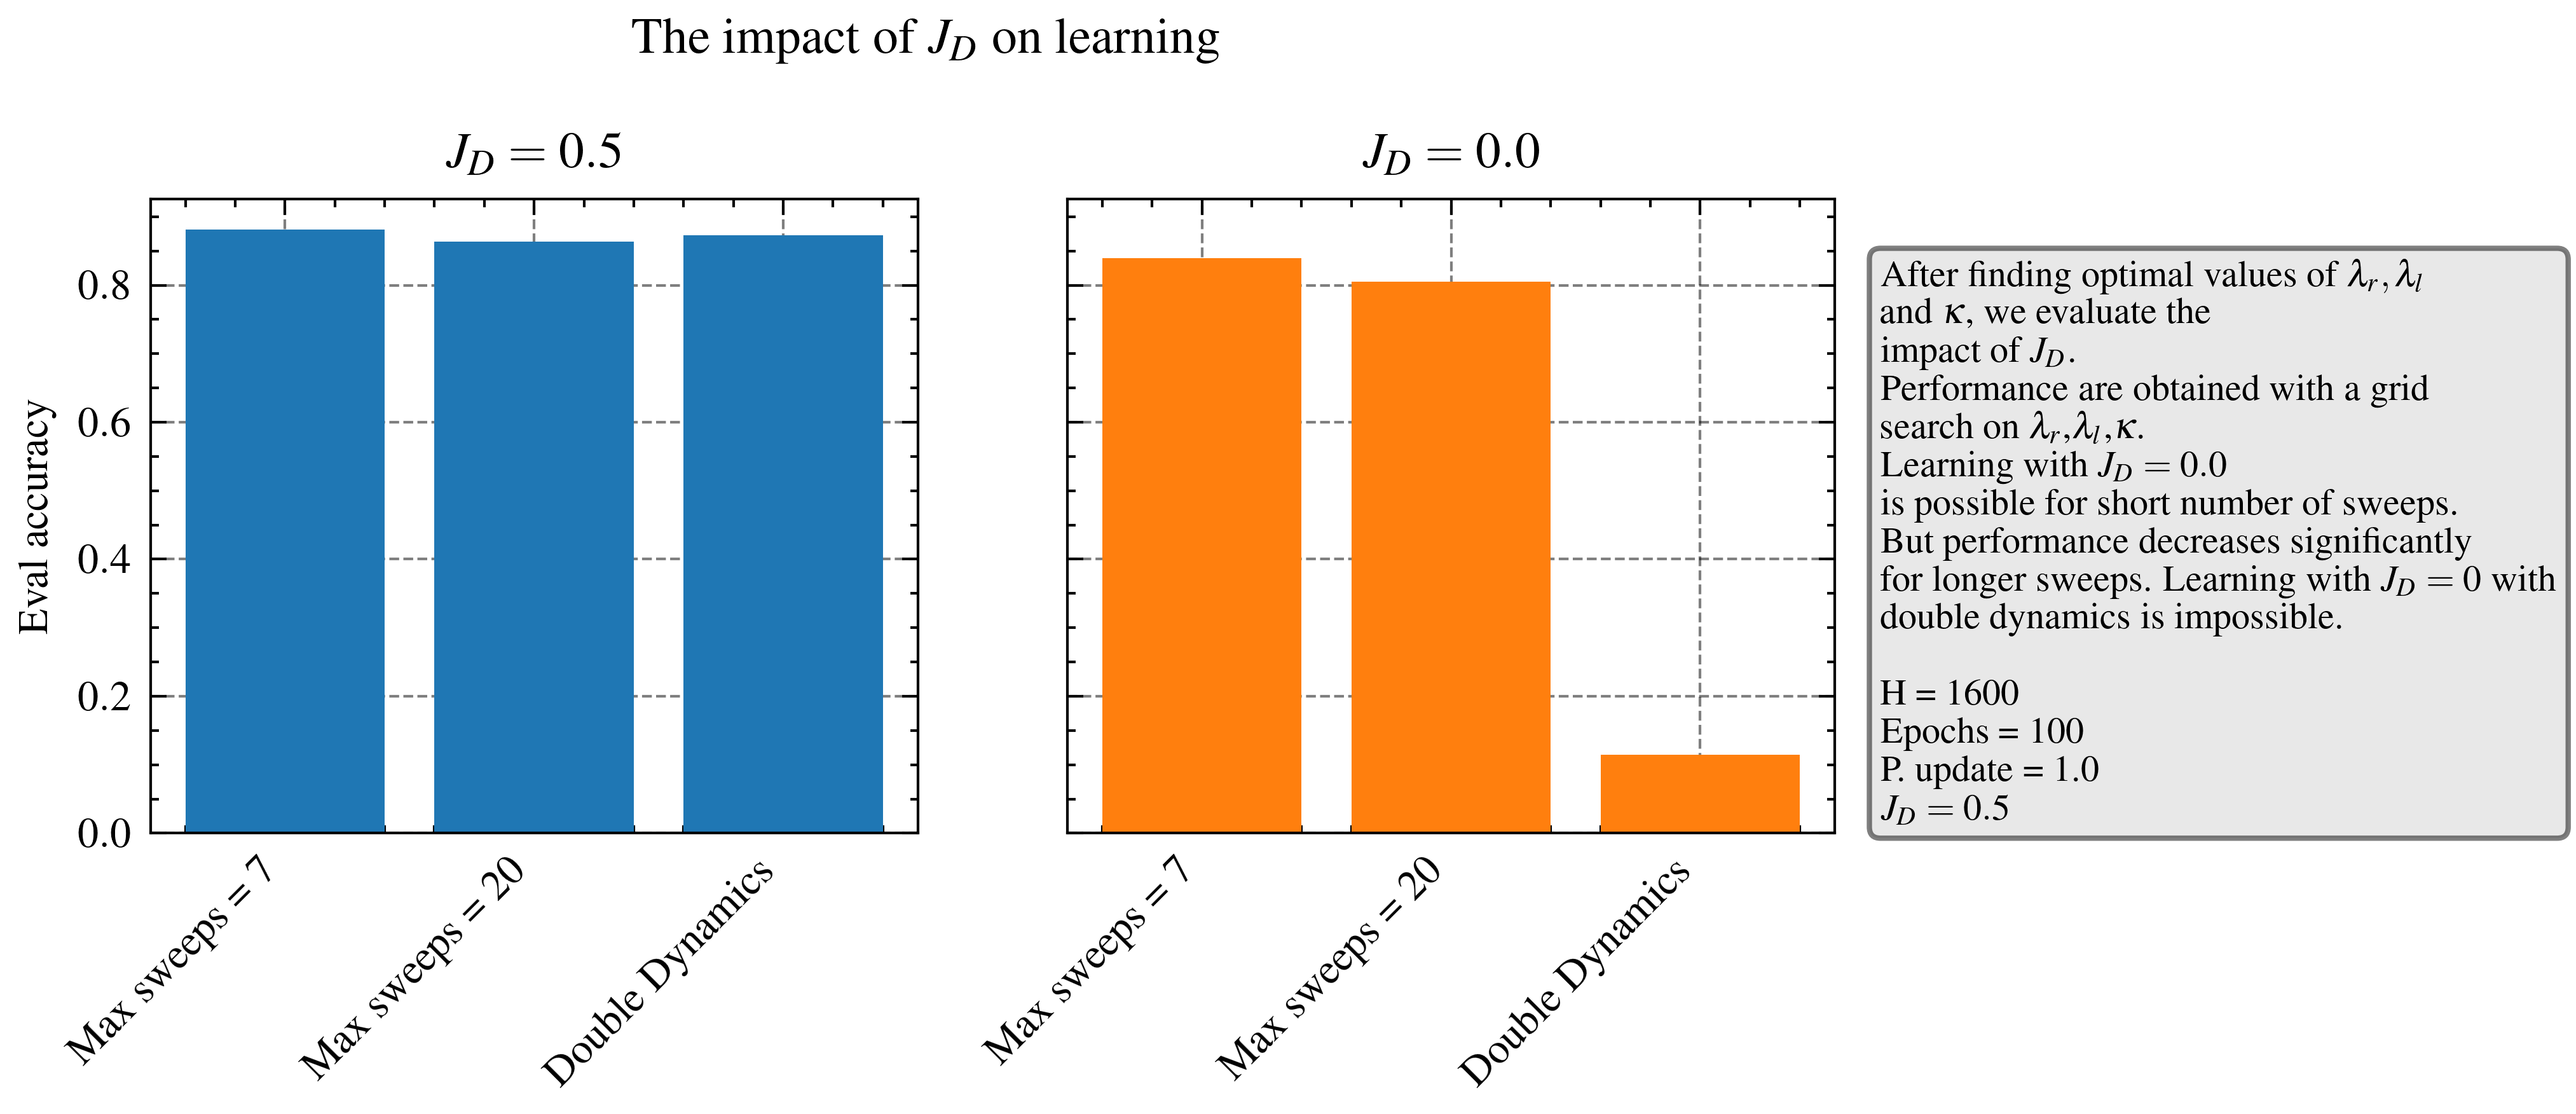

In [120]:
import matplotlib.pyplot as plt

data_dict = {
    "jd_low": data_jd_low.to_dict(orient="index")[1600],
    "jd_low_long": data_jd_low_long.to_dict(orient="index")[1600],
    "jd_low_double": data_jd_low_double.to_dict(orient="index")[1600],
    "jd_high": data_jd_high.to_dict(orient="index")[1600],
    "jd_high_long": data_jd_high_long.to_dict(orient="index")[1600],
    "jd_high_double": data_jd_high_double.to_dict(orient="index")[1600],
}
plot_description = """After finding optimal values of $\lambda_r, \lambda_l$
and $\kappa$, we evaluate the 
impact of $J_D$. 
Performance are obtained with a grid 
search on $\lambda_r$,$\lambda_l$,$\kappa$.
Learning with $J_D=0.0$
is possible for short number of sweeps.
But performance decreases significantly
for longer sweeps. Learning with $J_D=0$ with 
double dynamics is impossible.

H = 1600
Epochs = 100
P. update = 1.0
$J_D=0.5$"""

# Split keys for high and low J_D
keys = list(data_dict.keys())
jd_high_keys = ["Max sweeps = 7", "Max sweeps = 20", "Double Dynamics"]
jd_low_keys = ["Max sweeps = 7", "Max sweeps = 20", "Double Dynamics"]

# Prepare data
jd_high_vals = [data_dict[k]["max_eval_acc"] for k in data_dict.keys() if "high" in k]
jd_low_vals = [data_dict[k]["max_eval_acc"] for k in data_dict.keys() if "low" in k]

fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharey=True)
axes[0].bar(jd_high_keys, jd_high_vals, color="tab:blue")
axes[0].set_title("$J_D = 0.5$")
axes[0].set_ylabel("Eval accuracy")
axes[0].set_xticklabels(jd_high_keys, rotation=45, ha="right")

axes[1].bar(jd_low_keys, jd_low_vals, color="tab:orange")
axes[1].set_title("$J_D = 0.0$")
axes[1].set_xticklabels(jd_low_keys, rotation=45, ha="right")

plt.suptitle("The impact of $J_D$ on learning")
props = dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
text = fig.text(1.00, 0.77, plot_description, ha="left", fontsize=7, va="top", bbox=props)    
plt.tight_layout()
plt.show()